In [4]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as ss
%matplotlib inline
import seaborn as sns
import warnings 
from ta.volatility import BollingerBands
from ta.momentum import rsi,stochrsi_k
from ta.trend import cci,macd
from ta.volatility import average_true_range,BollingerBands
from ta.volume import AccDistIndexIndicator,AccDistIndexIndicator,acc_dist_index
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,log_loss,silhouette_score
from sklearn.metrics import plot_confusion_matrix,roc_curve,roc_auc_score,plot_roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

## 1. LSTM model for Nasdaq-100 Index

In [5]:
# Downloading NDX data from Yahoo Finance
ndx_data = yf.download('NDX', start='2010-01-01', end='2021-12-31')
df = pd.DataFrame(ndx_data['Adj Close'])
# Calculating returns using log differences
df['Return'] = np.log(df).diff()

# Reset the index
df = df.reset_index()
# Set the date as the new index, without time information
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')

df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Return
Date,,
2009-12-31,1860.310059,NaN
2010-01-04,1886.699951,0.014086
2010-01-05,1888.430054,0.000917
2010-01-06,1878.420044,-0.005315
2010-01-07,1876.719971,-0.000905


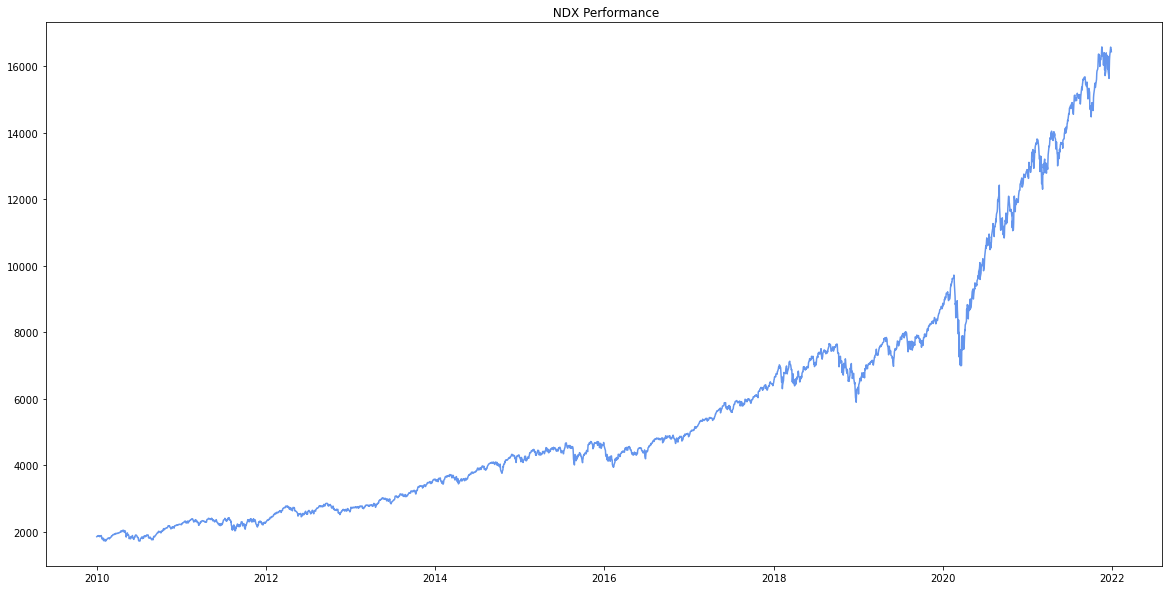

In [6]:
# Visualize raw price series
plt.figure(figsize=(20,10))
plt.title(' NDX Performance')
plt.plot(df['Adj Close'], color='cornflowerblue');

In [7]:
def features(df):
    df['O-C'] = ndx_data['Open'] - ndx_data['Close']
    df['H-L'] = ndx_data['High'] - ndx_data['Low']
    #df['UpperBand'] = df['Adj Close'].rolling(20).mean() + df['Adj Close'].rolling(20).std() * 2
    #df['LowerBand'] = df['Adj Close'].rolling(20).mean() - df['Adj Close'].rolling(20).std() * 2
    df['Relative']=rsi(ndx_data['Close'],window=14)
    df['Stochatic_k']=stochrsi_k(ndx_data['Close'])
    df['CCI']=cci(ndx_data['High'],ndx_data['Low'],ndx_data['Close'])
    df["ATR"]=average_true_range(ndx_data['High'],ndx_data['Low'],ndx_data['Close'])
    df['macd']=macd(ndx_data.Close,window_fast=112,window_slow=26)
    df['AccDist']=acc_dist_index(ndx_data['High'],ndx_data['Low'],ndx_data['Close'],ndx_data['Volume'])
    df['Return_1d']= df['Return'].shift(periods=1)
    df['Return_2d']= df['Return'].shift(periods=2)
    df['Return_5d']= df['Return'].shift(periods=5)
    df['Momentum_1d']=df['Adj Close']-df['Adj Close'].shift(periods=1)
    df['Momentum_2d']=df['Adj Close']-df['Adj Close'].shift(periods=2)
    df['Momentum_5d']=df['Adj Close']-df['Adj Close'].shift(periods=5)
    df['MA_5d']=df['Adj Close'].rolling(5).mean()
    df['MA_10d']=df['Adj Close'].rolling(10).mean()
    df['MA_20d']=df['Adj Close'].rolling(20).mean()
    df['MA_50d']=df['Adj Close'].rolling(20).mean()
    df['EMA_5d']=df['Adj Close'].ewm(5, adjust=False).mean()
    df['EMA_10d']=df['Adj Close'].ewm(10, adjust=False).mean()
    df['EMA_20d']=df['Adj Close'].ewm(20, adjust=False).mean()
    df['EMA_50d']=df['Adj Close'].ewm(50, adjust=False).mean()
    return df

In [8]:
# Drift-independent volatility (YZ estimator)
def yz(df, lookback=10):
    o = df.Open
    h = df.High
    l = df.Low
    c = df.Close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(window=lookback).sum()* (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

# Volume weighted average price
def vwap(df):
    v = df['Volume'].values
    tp = (df['Low'] + df['Close'] + df['High']).div(3).values
    return df.assign(vwap=(tp * v).cumsum() / v.cumsum()).vwap

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=ndx_data["Close"], window=20, window_dev=2)
df['Bollinger_BandM']=indicator_bb.bollinger_mavg()
df['Bollinger_BandH']=indicator_bb.bollinger_hband()
df['Bollinger_BandL']=indicator_bb.bollinger_lband()

In [9]:
features(df)
df['drift_volatility']=yz(ndx_data)
df['VWAP']=vwap(ndx_data)
# Drop NaN values
df.dropna(inplace=True)
df.head()

,Adj Close,Return,Bollinger_BandM,Bollinger_BandH,Bollinger_BandL,O-C,H-L,Relative,Stochatic_k,CCI,...,MA_5d,MA_10d,MA_20d,MA_50d,EMA_5d,EMA_10d,EMA_20d,EMA_50d,drift_volatility,VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-11,1847.150024,0.009279,1842.040009,1921.341832,1762.738185,-32.900024,36.630005,47.404294,0.605689,-12.980080,...,1810.004004,1834.474011,1842.040009,1842.040009,1832.410335,1853.942195,1884.257576,1894.900802,28.093656,1890.632952
2010-06-14,1845.479980,-0.000905,1838.959009,1912.488702,1765.429315,17.219971,32.779907,47.186059,0.787535,37.199125,...,1819.467993,1833.783008,1838.959009,1838.959009,1834.588609,1853.172903,1882.411024,1893.931766,28.353870,1890.387020
2010-06-15,1897.479980,0.027787,1838.060510,1908.190066,1767.930954,-41.790039,43.100098,54.248745,0.888267,108.809949,...,1839.823999,1840.027002,1838.060510,1838.060510,1845.070504,1857.200819,1883.128593,1894.001339,27.238999,1890.334867
2010-06-16,1905.310059,0.004118,1838.973010,1912.042383,1765.903638,-14.050049,24.989990,55.219824,0.942009,151.450672,...,1865.102002,1842.599011,1838.973010,1838.973010,1855.110430,1861.574386,1884.184853,1894.223078,26.289391,1890.416414
2010-06-17,1910.650024,0.002799,1840.834509,1919.035991,1762.633028,4.099976,21.969971,55.907172,1.000000,149.710801,...,1881.214014,1844.098010,1840.834509,1840.834509,1864.367029,1866.035808,1885.445100,1894.545175,26.359104,1890.522875


# Assigning the Label

The label is a crucial component that determines the outcome of the prediction made by the Long Short-Term Memory (LSTM) model.
The label represents the target variable, or the dependent variable, which the model is trying to predict. 
In this case, the target variable is whether the NDX index price will close up or down on the next trading day. 
Based on this prediction, a decision is made to either buy the NDX (if the tomorrow's closing price is greater than today's closing price) or sell NDX (if the tomorrow's closing price is lower than today's closing price).
If there is no change between the closing prices of today's and tomorrow's, then the position is considered neutral. 
In short, the label provides the ground truth for the LSTM model to make predictions and help traders make informed investment decisions.

Assigning +1 for the buy signal and 0 for sell. Target can be described as:

\begin{equation}
y_t= \begin{cases}+1, & \text { if } p_t+1>p_t \\ 0, & \text { if } p_t+1<p_t\end{cases}
\end{equation}    

In [10]:
df['Target']=np.where(df['Adj Close'].shift(-1)>df['Adj Close'],1,np.where(df['Adj Close'].shift(-1)<df['Adj Close'],0,-1))
df.drop(df[df['Target']==-1].index,inplace=True)
df['Target'].value_counts(normalize=True)

1    0.560179
0    0.439821
Name: Target, dtype: float64

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

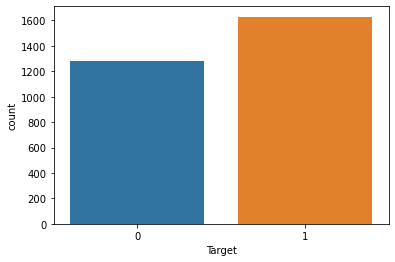

In [11]:
# The -1 classes were excluded from the dataset due to a small sample size and to prevent over- or under-prediction in the other classes, which are +1 and 0.

sns.countplot(df['Target'])

Text(0.5, 1.0, 'Feature Correlation')

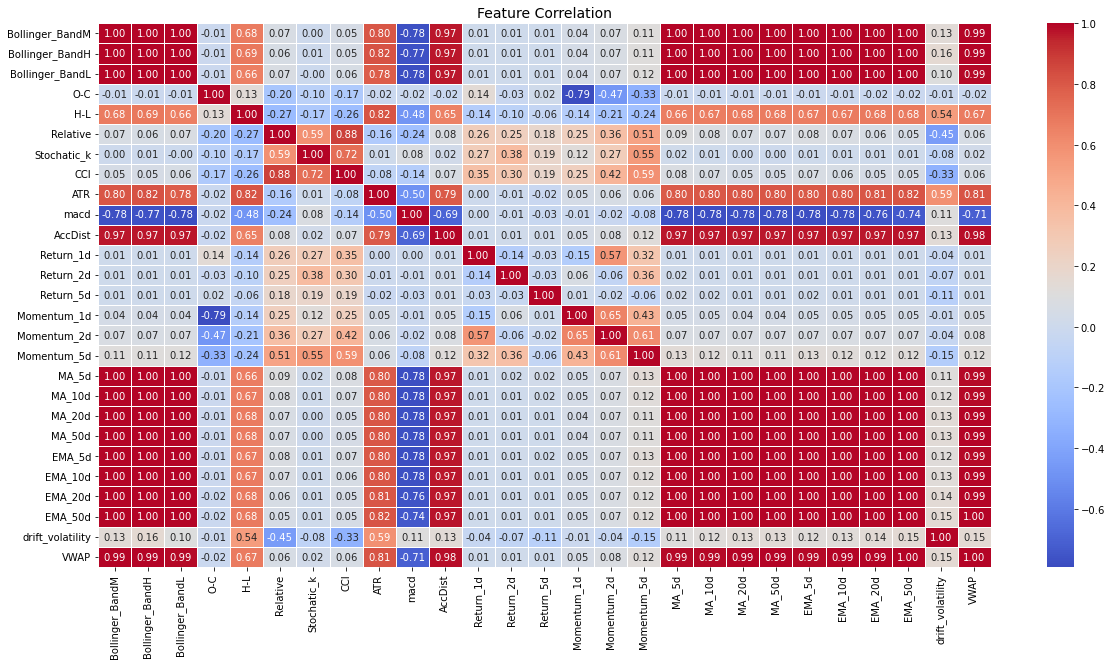

In [12]:
# Compute features correlation
import seaborn as sns
corrmat = df.drop(['Adj Close', 'Return', 'Target'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap="coolwarm")
ax.set_title('Feature Correlation', fontsize=14, color='black')

The features MA_5d, MA_10d, MA_20d, MA_50d, EMA_5d, EMA_10d, EMA20d, and EMA_50d in the correlation matrix are found to be highly correlated with each other. As a result, only one of these features will be selected for model construction. This correlation is also seen between Bollinger bands and VWAP.

# K means Clustering

In [13]:
df1=df.copy()
df1=df1.T
df1=df1.drop(['Adj Close','Target'])

In [14]:
X1=df1.iloc[:]
scaler_x = StandardScaler()
X1= scaler_x.fit_transform(X1)
X1.shape

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date']. An error will be raised in 1.2.
  FutureWarning,
/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date']. An error will be raised in 1.2.
  FutureWarning,


(28, 2908)

In [15]:
# implementing K-means clustering
score=[]
for k in range(2,13):
    model=KMeans(n_clusters=k)
    model.fit(X1)
    labels=model.labels_
    centroids = model.cluster_centers_
    score.append(model.inertia_)

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  """


In [16]:
clusters_df = pd.DataFrame({"Clusters": range(2,13), "Cluster_errors": score})
clusters_df

,Clusters,Cluster_errors
0,2,1.375962e-10
1,3,2.276197e-12
2,4,2.216881e-13
3,5,1.777085e-13
4,6,1.448344e-13
5,7,1.094176e-13
6,8,7.894351e-14
7,9,7.230399e-14
8,10,4.423172e-14
9,11,4.492447e-14


### Using the Elbow graph to Identify the appropriate clusters

Text(0, 0.5, 'Model Inertia')

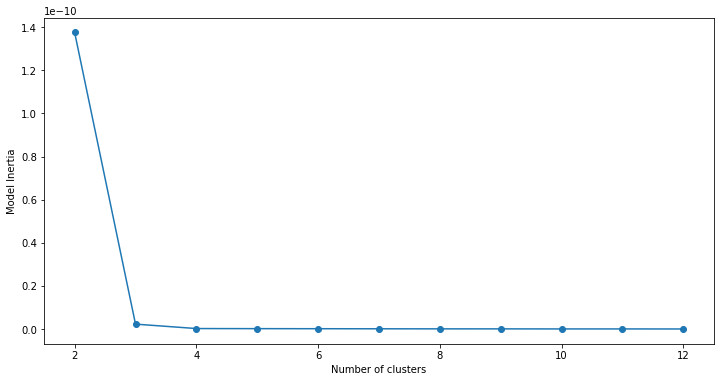

In [17]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.Clusters, clusters_df.Cluster_errors, marker = "o" )
plt.xlabel("Number of clusters")
plt.ylabel("Model Inertia")

Based on the Elbow plot, there is a noticeable bend at 3, therefore we have adjusted the KMeans clustering to have 3 clusters.

In [18]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X1)

KMeans(n_clusters=3, random_state=1)

In [19]:
predictions=kmeans.predict(X1)
predictions

array([0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2], dtype=int32)

### Cluster Analysis

In [20]:
df_cluster=pd.DataFrame({'Cluster':predictions,'Features':df1.index,
                         'Distance':df1.mean(axis=1),'Std Dev':df1.std(axis=1)}).sort_values(by=['Cluster'],axis=0)
df_cluster

,Cluster,Features,Distance,Std Dev
Return,0,Return,7.547421e-04,1.240353e-02
Momentum_5d,0,Momentum_5d,2.510156e+01,1.801561e+02
Momentum_2d,0,Momentum_2d,1.008654e+01,1.170344e+02
Momentum_1d,0,Momentum_1d,5.038256e+00,9.060487e+01
Return_5d,0,Return_5d,7.334613e-04,1.243170e-02
drift_volatility,0,drift_volatility,1.789404e+01,1.039608e+01
Return_1d,0,Return_1d,7.618578e-04,1.241269e-02
macd,0,macd,-1.984335e+02,2.606565e+02
ATR,0,ATR,8.582128e+01,7.415039e+01
Return_2d,0,Return_2d,7.616143e-04,1.241461e-02


### SOM Implementation

In [21]:
from minisom import MiniSom

df2 = pd.DataFrame(df_cluster)
X_SOM=df2[['Distance','Std Dev']]

scaler = StandardScaler()
X_SOM = scaler.fit_transform(X_SOM)

# Check if the array has any missing or NaN values
print(np.isnan(X_SOM).sum())

# Check if the array has any values for index 0
print(X_SOM[0])

# Initialize a 15x15 SOM
som = MiniSom(15, 15, 2, learning_rate=0.5, sigma=5, random_seed=42)

# Initialize with random weights
som.random_weights_init(X_SOM)

# Trains SOM with 10000 iterations
som.train_batch(X_SOM, 10000, verbose=True)

0
[-0.19245012 -0.19245012]


 [   600 / 10000 ]   6% - 0:00:06 left 

 [  1028 / 10000 ]  10% - 0:00:05 left 

 [  1432 / 10000 ]  14% - 0:00:04 left 

 [  1913 / 10000 ]  19% - 0:00:04 left 

 [  2370 / 10000 ]  24% - 0:00:03 left 

 [  2785 / 10000 ]  28% - 0:00:03 left 

 [  3165 / 10000 ]  32% - 0:00:03 left 

 [  3634 / 10000 ]  36% - 0:00:03 left 

 [  4041 / 10000 ]  40% - 0:00:03 left 

 [  4450 / 10000 ]  44% - 0:00:02 left 

 [  5166 / 10000 ]  52% - 0:00:02 left 

 [  5859 / 10000 ]  59% - 0:00:02 left 

 [  6336 / 10000 ]  63% - 0:00:01 left 

 [  6711 / 10000 ]  67% - 0:00:01 left 

 [  7253 / 10000 ]  73% - 0:00:01 left 

 [  7803 / 10000 ]  78% - 0:00:01 left 

 [  8371 / 10000 ]  84% - 0:00:00 left 

 [  8863 / 10000 ]  89% - 0:00:00 left 

 [  9259 / 10000 ]  93% - 0:00:00 left 

 [  9813 / 10000 ]  98% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.6251601282067977e-09


/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


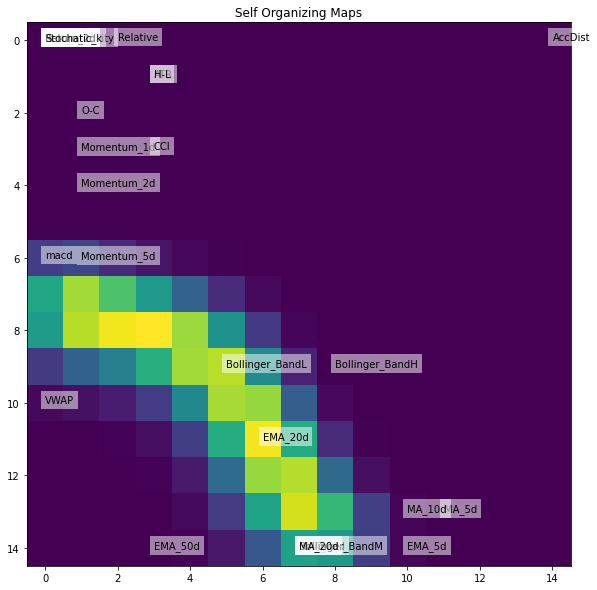

In [22]:
# Plotting SOM
plt.figure(figsize=(20, 10))
for ix in range(len(X_SOM)):
    winner = som.winner(X_SOM[ix])
    plt.text(winner[0], winner[1], df_cluster.Features[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps');

The SOM was trained using the feature set X, and each data point was labeled based on the neuron it was assigned to in the SOM.

## Training the Model and Data Splitting

In [23]:
X_cols = [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 18, 22, 23, 27, 28]
X = df.iloc[:, X_cols].values

y = df.iloc[:, -1].values.reshape(-1, 1)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
X.shape

(2908, 17)

In [24]:
def lstm_data_transform(x_data, y_data, num_steps):
    x_shape = (x_data.shape[0] - num_steps, num_steps, x_data.shape[1])
    x_array = np.zeros(x_shape)
    y_array = y_data[num_steps:]
    for i in range(num_steps):
        x_array[:, i, :] = x_data[i:x_shape[0]+i]
    return x_array, y_array

In [25]:
num_steps_list = [5, 10, 21, 50, 200]
for num_steps in num_steps_list:
    X_new, y_new = lstm_data_transform(X, y, num_steps=num_steps)
    print("The new shape of x is", X_new.shape)
    print("\n")

The new shape of x is (2903, 5, 17)


The new shape of x is (2898, 10, 17)


The new shape of x is (2887, 21, 17)


The new shape of x is (2858, 50, 17)


The new shape of x is (2708, 200, 17)




To use LSTM, the input data must have three dimensions in the format of [samples, timesteps, features].

In [26]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    # Print the shape of the train data for the current num_steps value
    print(f"The new shape of x for num_steps={n} is {x_train.shape}")
    print()

The new shape of x for num_steps=5 is (2032, 5, 17)

The new shape of x for num_steps=10 is (2028, 10, 17)

The new shape of x for num_steps=21 is (2020, 21, 17)

The new shape of x for num_steps=50 is (2000, 50, 17)

The new shape of x for num_steps=200 is (1895, 200, 17)



In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def base_model(X_new):
    # Define the model
    model = Sequential([
        LSTM(units=200, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100),
        Dropout(0.2),
        Dense(units=100, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Print the model summary
    model.summary()
    return model

### Implementing an LSTM model with a 5-day lookback period

In [28]:
# Transform the data with 5 timesteps
X_new5, y_new5 = lstm_data_transform(X, y, num_steps=5)

# Print the new shape of X for num_steps=5
print(f"The new shape of X for num_steps=5 is {X_new5.shape}")

# Build the LSTM model using the transformed data with 5 timesteps
model5 = base_model(X_new5)

The new shape of X for num_steps=5 is (2903, 5, 17)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            174400    
_________________________________________________________________
dropout (Dropout)            (None, 5, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm

In [29]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=5 only
x_train_5 = x_train_list[0]
y_train_5 = y_train_list[0]
x_test_5 = x_test_list[0]
y_test_5 = y_test_list[0]

# Train and evaluate the model for num_steps=5
hist5=model5.fit(x_train_5,y_train_5,epochs=10,batch_size=64)
Eva5=model5.evaluate(x_test_5,y_test_5)
print('Test accuracy: ', np.round(Eva5[1],4))

Epoch 1/10
32/32 [==============================] - 26s 158ms/step - loss: 0.6929 - accuracy: 0.5221
Epoch 2/10
32/32 [==============================] - 5s 140ms/step - loss: 0.6907 - accuracy: 0.5507
Epoch 3/10
32/32 [==============================] - 5s 171ms/step - loss: 0.6892 - accuracy: 0.5507
Epoch 4/10
32/32 [==============================] - 6s 192ms/step - loss: 0.6897 - accuracy: 0.5507
Epoch 5/10
32/32 [==============================] - 4s 135ms/step - loss: 0.6890 - accuracy: 0.5507
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.6897 - accuracy: 0.5507
Epoch 7/10
32/32 [==============================] - 5s 143ms/step - loss: 0.6891 - accuracy: 0.5507
Epoch 8/10
32/32 [==============================] - 6s 172ms/step - loss: 0.6879 - accuracy: 0.5507
Epoch 9/10
32/32 [==============================] - 6s 186ms/step - loss: 0.6891 - accuracy: 0.5507
Epoch 10/10
28/28 [==============================] - 8s 142ms/step - loss: 0.6812 - accuracy: 0.580

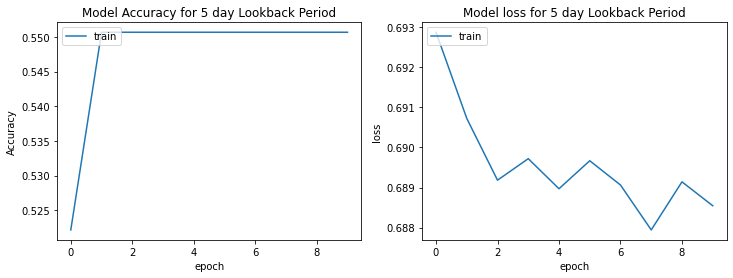

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist5.history['accuracy'])
ax1.set_title("Model Accuracy for 5 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("epoch")
ax1.legend(['train'], loc='upper left')

# Plot loss
ax2.plot(hist5.history['loss'])
ax2.set_title('Model loss for 5 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')

plt.show()

#### Confusion Matrix

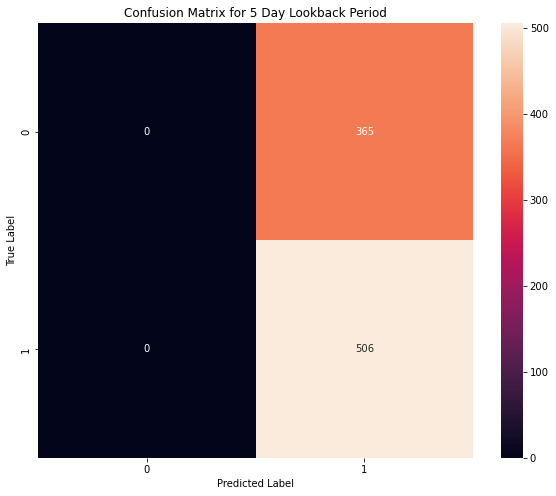

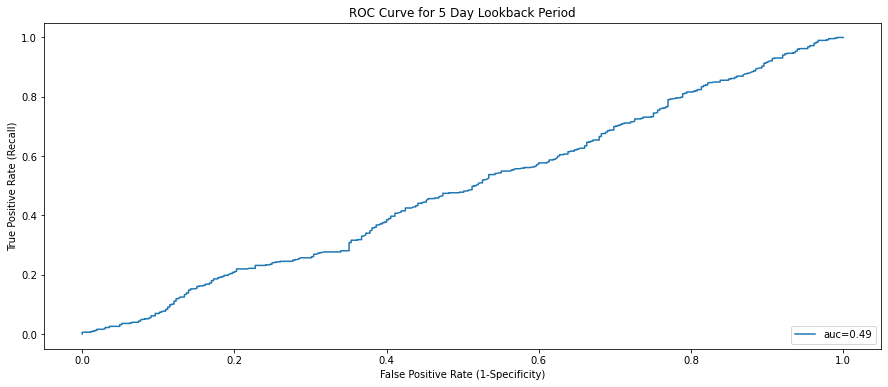

In [31]:
y_pred5=model5.predict(x_test_5)
y_pred5 = np.round(y_pred5).astype(int)
cm5=confusion_matrix(y_test_5,y_pred5)
plt.figure(figsize=(10,8))
sns.heatmap(cm5,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 5 Day Lookback Period")

y_prob5=model5.predict(x_test_5)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_5,y_prob5),2)
fpr,tpr,_=roc_curve(y_test_5,y_prob5, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 5 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 10-day lookback period

In [32]:
# Transform the data with 10 timesteps
X_new10, y_new10 = lstm_data_transform(X, y, num_steps=10)

# Print the new shape of X for num_steps=10
print(f"The new shape of X for num_steps=10 is {X_new10.shape}")

# Build the LSTM model using the transformed data with 10 timesteps
model10 = base_model(X_new10)

The new shape of X for num_steps=10 is (2898, 10, 17)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 200)           174400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 100)           120400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________


In [33]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=10 only
x_train_10 = x_train_list[1]
y_train_10 = y_train_list[1]
x_test_10 = x_test_list[1]
y_test_10 = y_test_list[1]

# Train and evaluate the model for num_steps=10
hist10=model10.fit(x_train_10,y_train_10,epochs=10,batch_size=64)
Eva10=model10.evaluate(x_test_10,y_test_10)
print('Test accuracy: ', np.round(Eva10[1],4))

Epoch 1/10
32/32 [==============================] - 1028s 2s/step - loss: 0.6908 - accuracy: 0.5468
Epoch 2/10
32/32 [==============================] - 31s 886ms/step - loss: 0.6915 - accuracy: 0.5498
Epoch 3/10
32/32 [==============================] - 11s 332ms/step - loss: 0.6884 - accuracy: 0.5503
Epoch 4/10
32/32 [==============================] - 15s 469ms/step - loss: 0.6891 - accuracy: 0.5483
Epoch 5/10
32/32 [==============================] - 20s 609ms/step - loss: 0.6889 - accuracy: 0.5513
Epoch 6/10
32/32 [==============================] - 14s 452ms/step - loss: 0.6910 - accuracy: 0.5518
Epoch 7/10
32/32 [==============================] - 10s 304ms/step - loss: 0.6886 - accuracy: 0.5518
Epoch 8/10
32/32 [==============================] - 11s 338ms/step - loss: 0.6902 - accuracy: 0.5493
Epoch 9/10
32/32 [==============================] - 13s 401ms/step - loss: 0.6886 - accuracy: 0.5523
Epoch 10/10
28/28 [==============================] - 5s 54ms/step - loss: 0.6815 - accuracy:

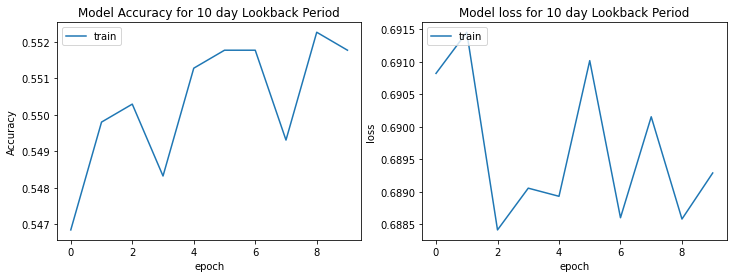

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist10.history['accuracy'])
ax1.set_title("Model Accuracy for 10 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("epoch")
ax1.legend(['train'], loc='upper left')

# Plot loss
ax2.plot(hist10.history['loss'])
ax2.set_title('Model loss for 10 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')

plt.show()

#### Confusion Matrix

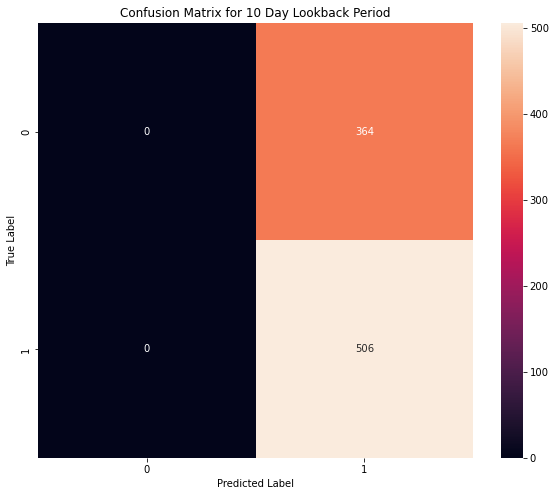

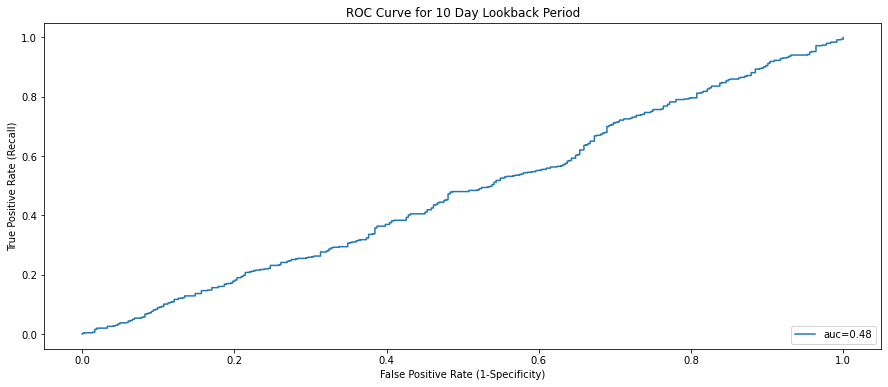

In [35]:
y_pred10=model10.predict(x_test_10)
y_pred10 = np.round(y_pred10).astype(int)
cm_10=confusion_matrix(y_test_10,y_pred10)
plt.figure(figsize=(10,8))
sns.heatmap(cm_10,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 10 Day Lookback Period")

y_prob10=model10.predict(x_test_10)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_10,y_prob10),2)
fpr,tpr,_=roc_curve(y_test_10,y_prob10, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 10 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 21-day lookback period

In [36]:
# Transform the data with 21 timesteps
X_new21, y_new21 = lstm_data_transform(X, y, num_steps=21)

# Print the new shape of X for num_steps=21
print(f"The new shape of X for num_steps=21 is {X_new21.shape}")

# Build the LSTM model using the transformed data with 21 timesteps
model21 = base_model(X_new21)

The new shape of X for num_steps=21 is (2887, 21, 17)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 21, 200)           174400    
_________________________________________________________________
dropout_10 (Dropout)         (None, 21, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 21, 100)           120400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 21, 100)           80400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________


In [37]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=21 only
x_train_21 = x_train_list[2]
y_train_21 = y_train_list[2]
x_test_21 = x_test_list[2]
y_test_21 = y_test_list[2]

# Train and evaluate the model for num_steps=21
hist21=model21.fit(x_train_21,y_train_21,epochs=10,batch_size=64)
Eva21=model21.evaluate(x_test_21,y_test_21)
print('Test accuracy: ', np.round(Eva21[1],4))

Epoch 1/10
32/32 [==============================] - 70s 763ms/step - loss: 0.6962 - accuracy: 0.5262
Epoch 2/10
32/32 [==============================] - 17s 537ms/step - loss: 0.6904 - accuracy: 0.5450
Epoch 3/10
32/32 [==============================] - 17s 519ms/step - loss: 0.6904 - accuracy: 0.5446
Epoch 4/10
32/32 [==============================] - 16s 500ms/step - loss: 0.6911 - accuracy: 0.5480
Epoch 5/10
32/32 [==============================] - 18s 572ms/step - loss: 0.6900 - accuracy: 0.5515
Epoch 6/10
32/32 [==============================] - 17s 524ms/step - loss: 0.6887 - accuracy: 0.5500
Epoch 7/10
32/32 [==============================] - 17s 528ms/step - loss: 0.6896 - accuracy: 0.5515
Epoch 8/10
32/32 [==============================] - 17s 527ms/step - loss: 0.6896 - accuracy: 0.5495
Epoch 9/10
32/32 [==============================] - 19s 606ms/step - loss: 0.6890 - accuracy: 0.5515
Epoch 10/10
28/28 [==============================] - 10s 134ms/step - loss: 0.6795 - accura

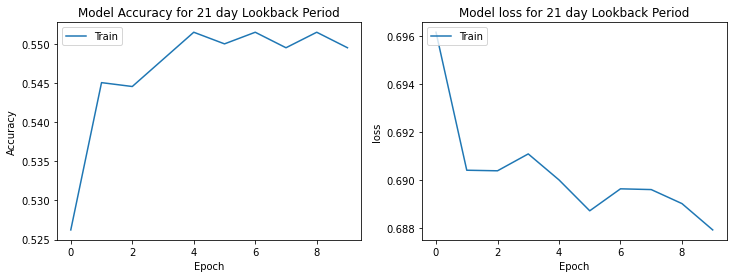

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist21.history['accuracy'])
ax1.set_title("Model Accuracy for 21 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')

# Plot loss
ax2.plot(hist21.history['loss'])
ax2.set_title('Model loss for 21 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')

plt.show()

#### Confusion Matrix

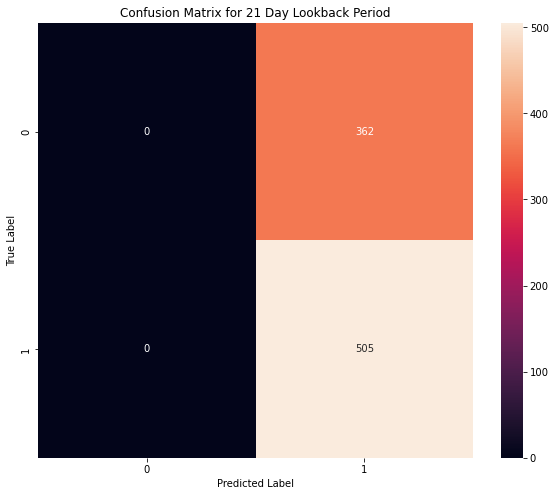

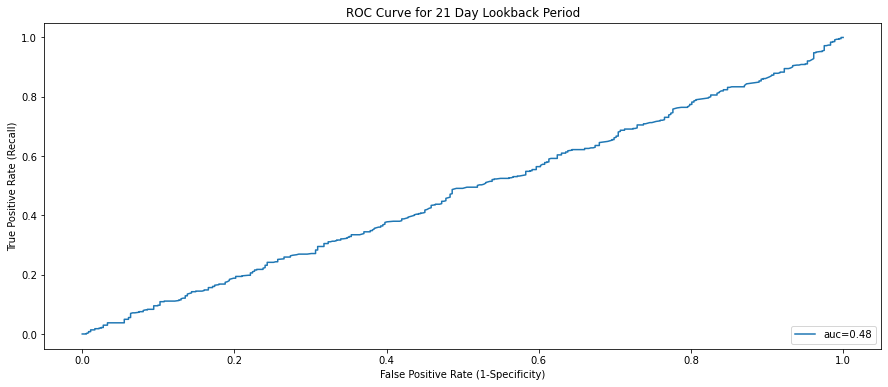

In [39]:
y_pred21=model21.predict(x_test_21)
y_pred21 = np.round(y_pred21).astype(int)
cm_21=confusion_matrix(y_test_21,y_pred21)
plt.figure(figsize=(10,8))
sns.heatmap(cm_21,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 21 Day Lookback Period")

y_prob21=model21.predict(x_test_21)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_21,y_prob21),2)
fpr,tpr,_=roc_curve(y_test_21,y_prob21, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 21 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 50-day lookback period

In [40]:
X_new50, y_new50 = lstm_data_transform(X, y, num_steps=50)

print(f"The new shape of X for num_steps=50 is {X_new50.shape}")

model50 = base_model(X_new50)

The new shape of X for num_steps=50 is (2858, 50, 17)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 200)           174400    
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 200)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 100)           120400    
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________


In [41]:
num_steps = [5, 10, 21, 50, 200]

x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

for n in num_steps:
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
x_train_50 = x_train_list[3]
y_train_50 = y_train_list[3]
x_test_50 = x_test_list[3]
y_test_50 = y_test_list[3]

hist50=model50.fit(x_train_50,y_train_50,epochs=10,batch_size=64)
Eva50=model50.evaluate(x_test_50,y_test_50)
print('Test accuracy: ', np.round(Eva50[1],4))

Epoch 1/10
32/32 [==============================] - 71s 1s/step - loss: 0.6916 - accuracy: 0.5260
Epoch 2/10
32/32 [==============================] - 49s 2s/step - loss: 0.6938 - accuracy: 0.5530
Epoch 3/10
32/32 [==============================] - 34s 1s/step - loss: 0.6913 - accuracy: 0.5360
Epoch 4/10
32/32 [==============================] - 40s 1s/step - loss: 0.6888 - accuracy: 0.5465
Epoch 5/10
32/32 [==============================] - 36s 1s/step - loss: 0.6891 - accuracy: 0.5530
Epoch 6/10
32/32 [==============================] - 36s 1s/step - loss: 0.6889 - accuracy: 0.5520
Epoch 7/10
32/32 [==============================] - 36s 1s/step - loss: 0.6879 - accuracy: 0.5530
Epoch 8/10
32/32 [==============================] - 38s 1s/step - loss: 0.6891 - accuracy: 0.5505
Epoch 9/10
32/32 [==============================] - 36s 1s/step - loss: 0.6884 - accuracy: 0.5545
Epoch 10/10
27/27 [==============================] - 8s 195ms/step - loss: 0.6805 - accuracy: 0.5816
Test accuracy:  0

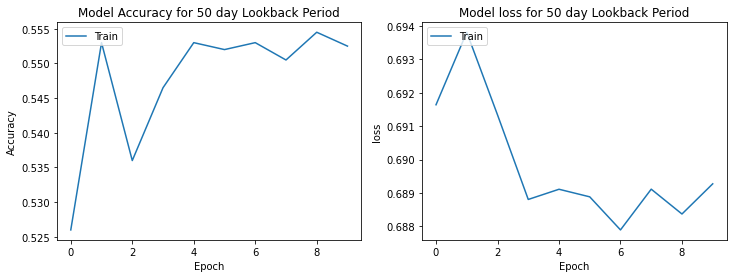

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist50.history['accuracy'])
ax1.set_title("Model Accuracy for 50 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')

# Plot loss
ax2.plot(hist50.history['loss'])
ax2.set_title('Model loss for 50 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')

plt.show()

#### Confusion Matrix

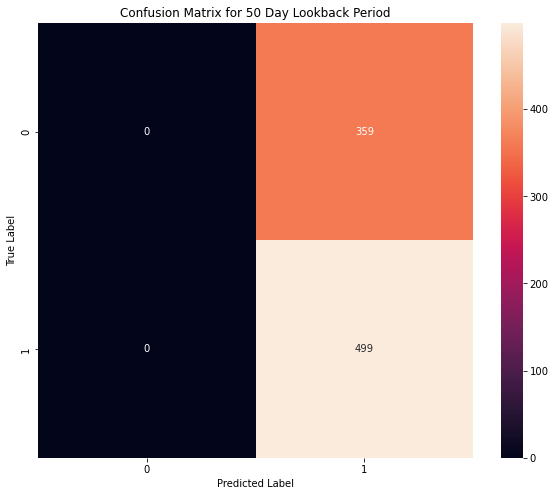

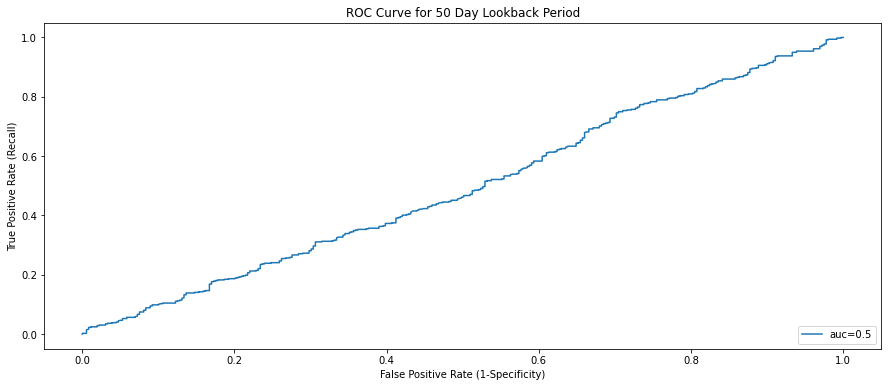

In [43]:
y_pred50=model50.predict(x_test_50)
y_pred50 = np.round(y_pred50).astype(int)
cm_50=confusion_matrix(y_test_50,y_pred50)
plt.figure(figsize=(10,8))
sns.heatmap(cm_50,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 50 Day Lookback Period")

y_prob50=model50.predict(x_test_50)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_50,y_prob50),2)
fpr,tpr,_=roc_curve(y_test_50,y_prob50, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 50 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Implementing an LSTM model with a 200-day lookback period

In [44]:
X_new200, y_new200 = lstm_data_transform(X, y, num_steps=200)

print(f"The new shape of X for num_steps=200 is {X_new200.shape}")

model200 = base_model(X_new200)

The new shape of X for num_steps=200 is (2708, 200, 17)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 200, 200)          174400    
_________________________________________________________________
dropout_20 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
dropout_21 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
dropout_22 (Dropout)         (None, 200, 100)          0         
________________________________________________________________

In [45]:
num_steps = [5, 10, 21, 50, 200]

x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

for n in num_steps:
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
x_train_200 = x_train_list[4]
y_train_200 = y_train_list[4]
x_test_200 = x_test_list[4]
y_test_200 = y_test_list[4]

hist200=model200.fit(x_train_200,y_train_200,epochs=10,batch_size=64)
Eva200=model200.evaluate(x_test_200,y_test_200)
print('Test accuracy: ', np.round(Eva200[1],4))

Epoch 1/10
30/30 [==============================] - 169s 5s/step - loss: 0.6943 - accuracy: 0.5230
Epoch 2/10
30/30 [==============================] - 123s 4s/step - loss: 0.6925 - accuracy: 0.5483
Epoch 3/10
30/30 [==============================] - 124s 4s/step - loss: 0.6901 - accuracy: 0.5441
Epoch 4/10
30/30 [==============================] - 145s 5s/step - loss: 0.6932 - accuracy: 0.5346
Epoch 5/10
30/30 [==============================] - 136s 5s/step - loss: 0.6891 - accuracy: 0.5467
Epoch 6/10
30/30 [==============================] - 128s 4s/step - loss: 0.6903 - accuracy: 0.5467
Epoch 7/10
30/30 [==============================] - 181s 6s/step - loss: 0.6906 - accuracy: 0.5483
Epoch 8/10
30/30 [==============================] - 254s 8s/step - loss: 0.6898 - accuracy: 0.5488
Epoch 9/10
30/30 [==============================] - 185s 6s/step - loss: 0.6909 - accuracy: 0.5488
Epoch 10/10
26/26 [==============================] - 26s 884ms/step - loss: 0.6857 - accuracy: 0.5855
Test ac

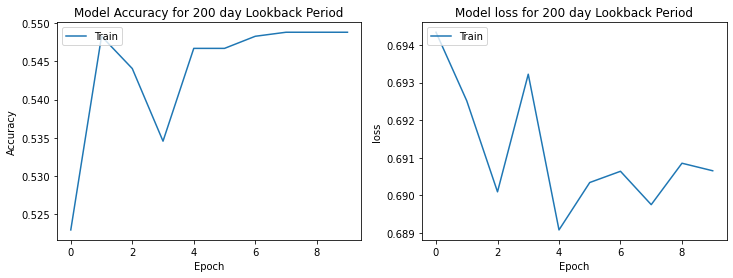

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist200.history['accuracy'])
ax1.set_title("Model Accuracy for 200 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')

# Plot loss
ax2.plot(hist200.history['loss'])
ax2.set_title('Model loss for 200 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')

plt.show()

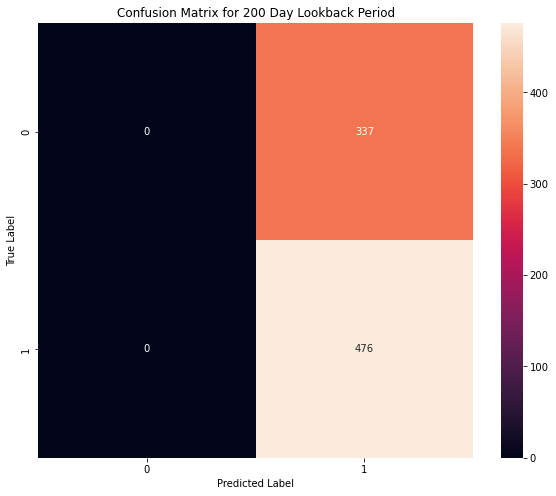

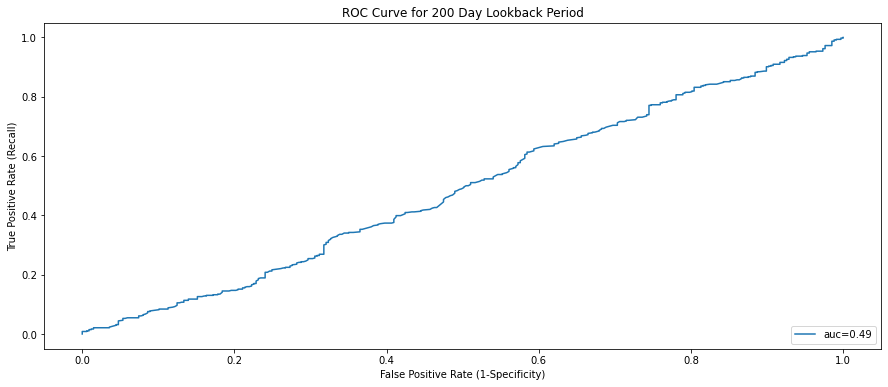

In [47]:
# Confusion Matrix
y_pred200=model200.predict(x_test_200)
y_pred200 = np.round(y_pred200).astype(int)
cm_200=confusion_matrix(y_test_200,y_pred200)
plt.figure(figsize=(10,8))
sns.heatmap(cm_200,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 200 Day Lookback Period")

y_prob200=model200.predict(x_test_200)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_200,y_prob200),2)
fpr,tpr,_=roc_curve(y_test_200,y_prob200, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title("ROC Curve for 200 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

## 2. LSTM model for EUR/USD FX rate.

### 2.1 Data Collection

In [48]:
# Downloading EUR/USD data from Yahoo Finance
eusd_data = yf.download('EURUSD=X', start='2010-01-01', end='2021-12-31')
df = pd.DataFrame(eusd_data['Adj Close'])
# Calculating returns using log differences
df['Return'] = np.log(df).diff()

# Reset the index
df = df.reset_index()
# Set the date as the new index, without time information
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')

df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Return
Date,,
2009-12-31,1.432706,NaN
2010-01-01,1.438994,0.004379
2010-01-04,1.442398,0.002363
2010-01-05,1.436596,-0.004031
2010-01-06,1.440403,0.002647


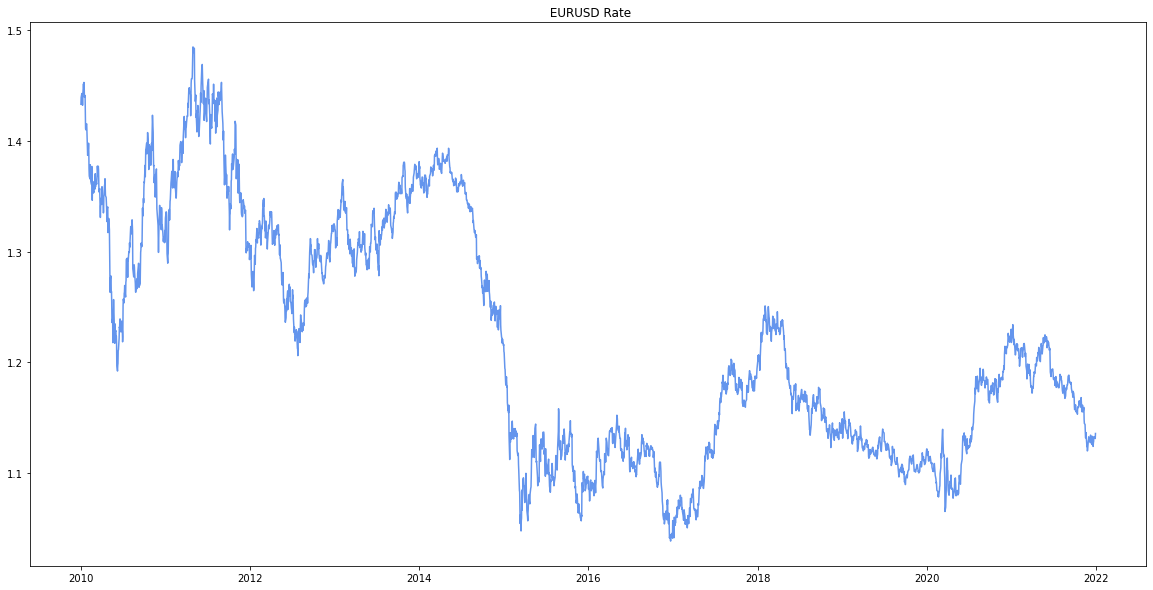

In [49]:
# Visualize raw price series
plt.figure(figsize=(20,10))
plt.title(' EURUSD Rate')
plt.plot(df['Adj Close'], color='cornflowerblue');

### 2.1 Feature Specification

In [50]:
# Create features (predictors) list

def features(df):
    df['O-C'] = eusd_data['Open'] - eusd_data['Close']
    df['H-L'] = eusd_data['High'] - eusd_data['Low']
    #df['UpperBand'] = df['Adj Close'].rolling(20).mean() + df['Adj Close'].rolling(20).std() * 2
    #df['LowerBand'] = df['Adj Close'].rolling(20).mean() - df['Adj Close'].rolling(20).std() * 2
    df['Relative']=rsi(eusd_data['Close'],window=14)
    df['Stochatic_k']=stochrsi_k(eusd_data['Close'])
    df['CCI']=cci(eusd_data['High'],eusd_data['Low'],eusd_data['Close'])
    df["ATR"]=average_true_range(eusd_data['High'],eusd_data['Low'],eusd_data['Close'])
    df['macd']=macd(eusd_data.Close,window_fast=112,window_slow=26)
    #df['AccDist']=acc_dist_index(eusd_data['High'],eusd_data['Low'],eusd_data['Close'],eusd_data['Volume'])
    df['Return_1d']= df['Return'].shift(periods=1)
    df['Return_2d']= df['Return'].shift(periods=2)
    df['Return_5d']= df['Return'].shift(periods=5)
    df['Momentum_1d']=df['Adj Close']-df['Adj Close'].shift(periods=1)
    df['Momentum_2d']=df['Adj Close']-df['Adj Close'].shift(periods=2)
    df['Momentum_5d']=df['Adj Close']-df['Adj Close'].shift(periods=5)
    df['MA_5d']=df['Adj Close'].rolling(5).mean()
    df['MA_10d']=df['Adj Close'].rolling(10).mean()
    df['MA_20d']=df['Adj Close'].rolling(20).mean()
    df['MA_50d']=df['Adj Close'].rolling(20).mean()
    df['EMA_5d']=df['Adj Close'].ewm(5, adjust=False).mean()
    df['EMA_10d']=df['Adj Close'].ewm(10, adjust=False).mean()
    df['EMA_20d']=df['Adj Close'].ewm(20, adjust=False).mean()
    df['EMA_50d']=df['Adj Close'].ewm(50, adjust=False).mean()
    return df

In [51]:
# Drift-independent volatility (YZ estimator)
def yz(df, lookback=10):
    o = df.Open
    h = df.High
    l = df.Low
    c = df.Close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(window=lookback).sum()* (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=eusd_data["Close"], window=20, window_dev=2)
df['Bollinger_BandM']=indicator_bb.bollinger_mavg()
df['Bollinger_BandH']=indicator_bb.bollinger_hband()
df['Bollinger_BandL']=indicator_bb.bollinger_lband()

In [52]:
features(df)
df['drift_volatility']=yz(eusd_data)
# Drop NaN values
df.dropna(inplace=True)
df.head()

,Adj Close,Return,Bollinger_BandM,Bollinger_BandH,Bollinger_BandL,O-C,H-L,Relative,Stochatic_k,CCI,...,Momentum_5d,MA_5d,MA_10d,MA_20d,MA_50d,EMA_5d,EMA_10d,EMA_20d,EMA_50d,drift_volatility
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-04,1.197103,-0.016439,1.236759,1.274614,1.198904,0.019990,0.025872,29.076384,0.625545,-146.349688,...,-0.030298,1.218007,1.223913,1.236759,1.236759,1.225234,1.242212,1.271290,1.322500,15.998472
2010-06-07,1.192293,-0.004026,1.232478,1.270111,1.194845,0.002122,0.010698,28.046158,0.366108,-195.075834,...,-0.036495,1.210708,1.219643,1.232478,1.232478,1.219744,1.237674,1.267528,1.319947,15.675354
2010-06-08,1.197203,0.004110,1.229188,1.267078,1.191299,-0.004896,0.010394,30.743859,0.216560,-169.143490,...,-0.026098,1.205489,1.215903,1.229188,1.229188,1.215987,1.233995,1.264179,1.317540,14.355345
2010-06-09,1.199199,0.001666,1.225953,1.262458,1.189449,-0.002096,0.014729,31.861991,0.183340,-136.133556,...,-0.024701,1.200549,1.214093,1.225953,1.225953,1.213189,1.230832,1.261085,1.315220,14.450640
2010-06-10,1.210903,0.009713,1.223793,1.258444,1.189142,-0.011704,0.018295,38.167002,0.516674,-90.192850,...,-0.006042,1.199340,1.211704,1.223793,1.223793,1.212808,1.229020,1.258695,1.313174,14.236076


### 2.3 Assigning the label

The label is a crucial component that determines the outcome of the prediction made by the Long Short-Term Memory (LSTM) model.
The label represents the target variable, or the dependent variable, which the model is trying to predict. 
In this case, the target variable is whether the NDX index price will close up or down on the next trading day. 
Based on this prediction, a decision is made to either buy the NDX (if the tomorrow's closing price is greater than today's closing price) or sell NDX (if the tomorrow's closing price is lower than today's closing price).
If there is no change between the closing prices of today's and tomorrow's, then the position is considered neutral. 
In short, the label provides the ground truth for the LSTM model to make predictions and help traders make informed investment decisions.

Assigning +1 for the buy signal and 0 for sell. Target can be described as:

\begin{equation}
y_t= \begin{cases}+1, & \text { if } p_t+1>p_t \\ 0, & \text { if } p_t+1<p_t\end{cases}
\end{equation}    

In [53]:
df['Target']=np.where(df['Adj Close'].shift(-1)>df['Adj Close'],1,np.where(df['Adj Close'].shift(-1)<df['Adj Close'],0,-1))
df.drop(df[df['Target']==-1].index,inplace=True)
df['Target'].value_counts(normalize=True)

1    0.50384
0    0.49616
Name: Target, dtype: float64

The -1 classes were excluded from the dataset due to a small sample size and to prevent over- or under-prediction in the other classes, which are +1 

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

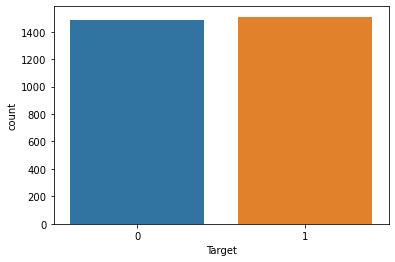

In [54]:
sns.countplot(df['Target'])

Text(0.5, 1.0, 'Feature Correlation')

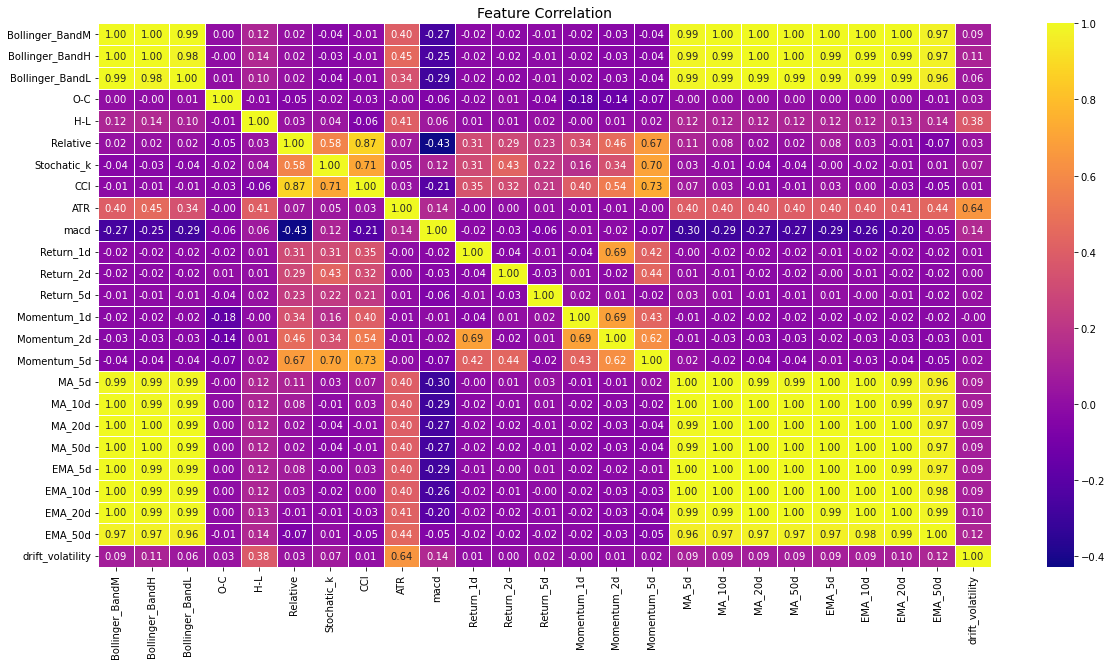

In [55]:
# Compute features correlation
import seaborn as sns
corrmat = df.drop(['Adj Close', 'Return', 'Target'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap="plasma")
ax.set_title('Feature Correlation', fontsize=14, color='black')

The features MA_5d, MA_10d, MA_20d, MA_50d, EMA_5d, EMA_10d, EMA20d, and EMA_50d in the correlation matrix are found to be highly correlated with each other. As a result, only one of these features will be selected for model construction. This correlation is also seen between Bollinger bands and drift volatility.

#### K means Clustering

In [56]:
df2=df.copy()
df2=df2.T
df2=df2.drop(['Adj Close','Target'])

In [57]:
X1=df2.iloc[:, 1:]
scaler_x = StandardScaler()
X1= scaler_x.fit_transform(X1)
X1.shape

/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date']. An error will be raised in 1.2.
  FutureWarning,
/home/fabulouskorex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['date']. An error will be raised in 1.2.
  FutureWarning,


(26, 2994)

In [58]:
# implementing K-means clustering
score=[]
for k in range(2,13):
    model=KMeans(n_clusters=k)
    model.fit(X1)
    labels=model.labels_
    centroids = model.cluster_centers_
    score.append(model.inertia_)

In [59]:
clusters_df = pd.DataFrame({"Clusters": range(2,13), "Cluster_errors": score})
clusters_df

,Clusters,Cluster_errors
0,2,28519.304592
1,3,2183.660726
2,4,94.243851
3,5,3.735483
4,6,0.030399
5,7,0.024020
6,8,0.018100
7,9,0.012393
8,10,0.007473
9,11,0.005370


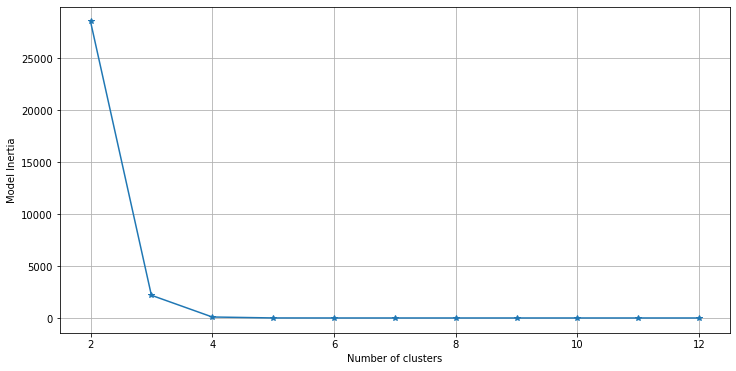

In [60]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.Clusters, clusters_df.Cluster_errors, marker = "*" )
plt.xlabel("Number of clusters")
plt.ylabel("Model Inertia")
plt.grid(True)

Based on the Elbow plot, there is a noticeable changes of the curve at 4, therefore we will adjust the KMeans clustering to have 4 clusters.

In [61]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X1)

KMeans(n_clusters=4, random_state=1)

In [62]:
predictions=kmeans.predict(X1)
predictions

array([0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3], dtype=int32)

In [63]:
df_cluster=pd.DataFrame({'Cluster':predictions,'Features':df2.index,
                         'Distance':df2.mean(axis=1),'Std Dev':df2.std(axis=1)}).sort_values(by=['Cluster'],axis=0)
df_cluster

,Cluster,Features,Distance,Std Dev
Return,0,Return,-0.000030,0.005397
EMA_20d,0,EMA_20d,1.215797,0.104573
EMA_10d,0,EMA_10d,1.215245,0.105443
EMA_5d,0,EMA_5d,1.215015,0.105919
MA_50d,0,MA_50d,1.215186,0.105766
MA_20d,0,MA_20d,1.215186,0.105766
MA_10d,0,MA_10d,1.214988,0.106115
MA_5d,0,MA_5d,1.214895,0.106297
Momentum_5d,0,Momentum_5d,-0.000180,0.014317
Momentum_2d,0,Momentum_2d,-0.000057,0.009226


#### SOM Implementation

In [64]:
from minisom import MiniSom

df3 = pd.DataFrame(df_cluster)
X_SOM=df3[['Distance','Std Dev']]

scaler = StandardScaler()
X_SOM = scaler.fit_transform(X_SOM)

# Check if the array has any missing or NaN values
print(np.isnan(X_SOM).sum())

# Check if the array has any values for index 0
print(X_SOM[0])

# Initialize a 15x15 SOM
som = MiniSom(15, 15, 2, learning_rate=0.5, sigma=5, random_seed=42)

# Initialize with random weights
som.random_weights_init(X_SOM)

# Trains SOM with 10000 iterations
som.train_batch(X_SOM, 10000, verbose=True)

0
[-0.2892939  -0.25040919]
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.0001476189898529767


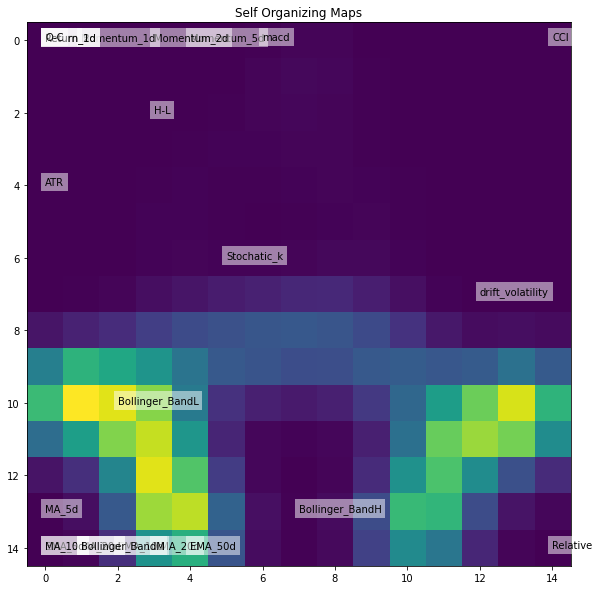

In [65]:
# Plotting SOM
plt.figure(figsize=(20, 10))
for ix in range(len(X_SOM)):
    winner = som.winner(X_SOM[ix])
    plt.text(winner[0], winner[1], df_cluster.Features[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps');

### 2.4 Training the Model and Data Splitting

In [66]:
X_cols = [0, 1, 2, 5, 7, 8, 9, 10, 11, 17, 25, 26]
X = df.iloc[:, X_cols].values

y = df.iloc[:, -1].values.reshape(-1, 1)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
X.shape

(2995, 12)

In [67]:
def lstm_data_transform(x_data, y_data, num_steps):
    x_shape = (x_data.shape[0] - num_steps, num_steps, x_data.shape[1])
    x_array = np.zeros(x_shape)
    y_array = y_data[num_steps:]
    for i in range(num_steps):
        x_array[:, i, :] = x_data[i:x_shape[0]+i]
    return x_array, y_array

In [68]:
num_steps_list = [5, 10, 21, 50, 200]
for num_steps in num_steps_list:
    X_new, y_new = lstm_data_transform(X, y, num_steps=num_steps)
    print("The new shape of x is", X_new.shape)
    print("\n")

The new shape of x is (2990, 5, 12)


The new shape of x is (2985, 10, 12)


The new shape of x is (2974, 21, 12)


The new shape of x is (2945, 50, 12)


The new shape of x is (2795, 200, 12)




To use LSTM, the input data must have three dimensions in the format of [samples, timesteps, features].

In [69]:
# Define the different num_steps values to use
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    # Print the shape of the train data for the current num_steps value
    print(f"The new shape of x for num_steps={n} is {x_train.shape}")
    print()

The new shape of x for num_steps=5 is (2093, 5, 12)

The new shape of x for num_steps=10 is (2089, 10, 12)

The new shape of x for num_steps=21 is (2081, 21, 12)

The new shape of x for num_steps=50 is (2061, 50, 12)

The new shape of x for num_steps=200 is (1956, 200, 12)



In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def base_model(X_new):
    # Define the model
    model = Sequential([
        LSTM(units=200, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100, activation='sigmoid', return_sequences=True),
        Dropout(0.2),
        LSTM(units=100),
        Dropout(0.2),
        Dense(units=100, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Print the model summary
    model.summary()
    return model

#### 2.4.1 Implementing an LSTM model with a 5-day lookback period for FX(EUR/USD)

In [71]:
# Transform the data with 5 timesteps
X_new5, y_new5 = lstm_data_transform(X, y, num_steps=5)

# Print the new shape of X for num_steps=5
print(f"The new shape of X for num_steps=5 is {X_new5.shape}")

# Build the LSTM model using the transformed data with 5 timesteps
model5 = base_model(X_new5)

The new shape of X for num_steps=5 is (2990, 5, 12)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 5, 200)            170400    
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 200)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 5, 100)            120400    
_________________________________________________________________
dropout_26 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
dropout_27 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
ls

In [72]:
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    

    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
x_train_5 = x_train_list[0]
y_train_5 = y_train_list[0]
x_test_5 = x_test_list[0]
y_test_5 = y_test_list[0]

# Train and evaluate the model for num_steps=5
hist5=model5.fit(x_train_5,y_train_5,epochs=10,batch_size=64)
Eva5=model5.evaluate(x_test_5,y_test_5)
print('Test accuracy: ', np.round(Eva5[1],4))

Epoch 1/10
33/33 [==============================] - 43s 425ms/step - loss: 0.6967 - accuracy: 0.4978
Epoch 2/10
33/33 [==============================] - 7s 222ms/step - loss: 0.6954 - accuracy: 0.4878
Epoch 3/10
33/33 [==============================] - 8s 255ms/step - loss: 0.6939 - accuracy: 0.5036
Epoch 4/10
33/33 [==============================] - 10s 295ms/step - loss: 0.6971 - accuracy: 0.4840
Epoch 5/10
33/33 [==============================] - 8s 240ms/step - loss: 0.6942 - accuracy: 0.4974
Epoch 6/10
33/33 [==============================] - 8s 250ms/step - loss: 0.6941 - accuracy: 0.4950
Epoch 7/10
33/33 [==============================] - 9s 269ms/step - loss: 0.6950 - accuracy: 0.4830
Epoch 8/10
33/33 [==============================] - 14s 425ms/step - loss: 0.6947 - accuracy: 0.4907
Epoch 9/10
33/33 [==============================] - 9s 257ms/step - loss: 0.6948 - accuracy: 0.4730
Epoch 10/10
29/29 [==============================] - 8s 70ms/step - loss: 0.6941 - accuracy: 0.49

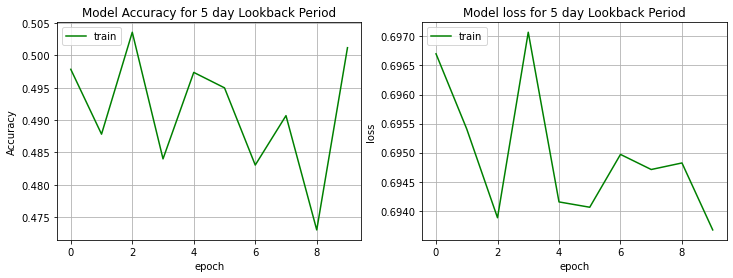

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist5.history['accuracy'], color='green')
ax1.set_title("Model Accuracy for 5 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("epoch")
ax1.legend(['train'], loc='upper left')
ax1.grid()

# Plot loss
ax2.plot(hist5.history['loss'], color='green')
ax2.set_title('Model loss for 5 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')

ax2.grid()

plt.show()

#### Confusion Matrix

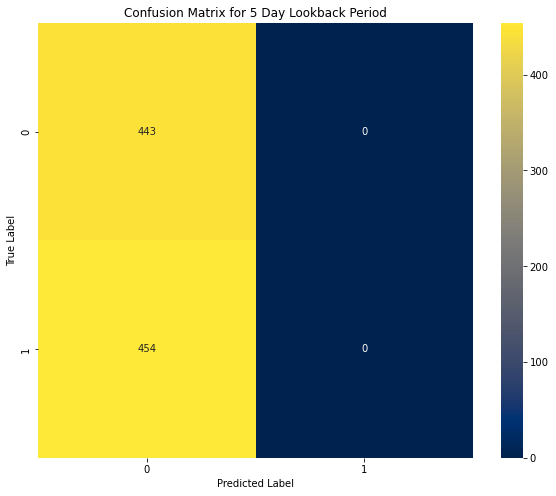

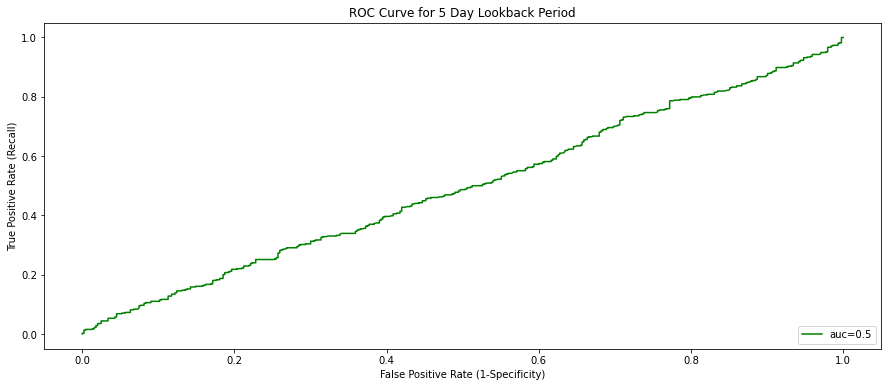

In [74]:
y_pred5=model5.predict(x_test_5)
y_pred5 = np.round(y_pred5).astype(int)
cm5=confusion_matrix(y_test_5,y_pred5)
plt.figure(figsize=(10,8))
sns.heatmap(cm5,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],cmap="cividis", square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 5 Day Lookback Period")

y_prob5=model5.predict(x_test_5)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_5,y_prob5),2)
fpr,tpr,_=roc_curve(y_test_5,y_prob5, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc), color='green')
plt.legend(loc="lower right")
plt.title("ROC Curve for 5 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

#### 2.4.2 Implementing an LSTM model with a 10-day lookback period

In [75]:
X_new10, y_new10 = lstm_data_transform(X, y, num_steps=10)

print(f"The new shape of X for num_steps=10 is {X_new10.shape}")

model10 = base_model(X_new10)

The new shape of X for num_steps=10 is (2985, 10, 12)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 200)           170400    
_________________________________________________________________
dropout_30 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 10, 100)           120400    
_________________________________________________________________
dropout_31 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 10, 100)           80400     
_________________________________________________________________
dropout_32 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________


In [76]:
num_steps = [5, 10, 21, 50, 200]

x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

for n in num_steps:
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
        
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
        
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
x_train_10 = x_train_list[1]
y_train_10 = y_train_list[1]
x_test_10 = x_test_list[1]
y_test_10 = y_test_list[1]

hist10=model10.fit(x_train_10,y_train_10,epochs=10,batch_size=64)
Eva10=model10.evaluate(x_test_10,y_test_10)
print('Test accuracy: ', np.round(Eva10[1],4))

Epoch 1/10
33/33 [==============================] - 44s 408ms/step - loss: 0.7024 - accuracy: 0.4849
Epoch 2/10
33/33 [==============================] - 13s 393ms/step - loss: 0.6949 - accuracy: 0.4998
Epoch 3/10
33/33 [==============================] - 13s 400ms/step - loss: 0.6941 - accuracy: 0.5160
Epoch 4/10
33/33 [==============================] - 15s 459ms/step - loss: 0.6949 - accuracy: 0.5002
Epoch 5/10
33/33 [==============================] - 14s 407ms/step - loss: 0.6959 - accuracy: 0.4926
Epoch 6/10
33/33 [==============================] - 19s 570ms/step - loss: 0.6969 - accuracy: 0.4844
Epoch 7/10
33/33 [==============================] - 18s 548ms/step - loss: 0.6942 - accuracy: 0.5084
Epoch 8/10
33/33 [==============================] - 14s 415ms/step - loss: 0.6936 - accuracy: 0.5132
Epoch 9/10
33/33 [==============================] - 12s 372ms/step - loss: 0.6953 - accuracy: 0.5036
Epoch 10/10
28/28 [==============================] - 7s 84ms/step - loss: 0.6930 - accuracy

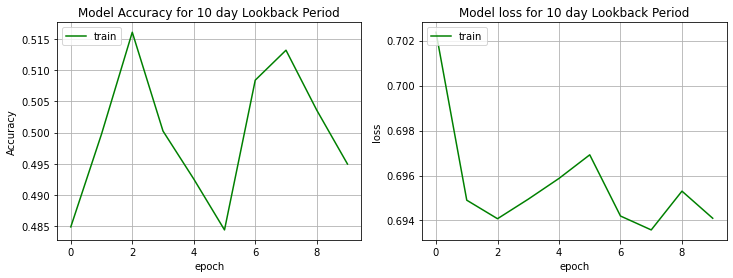

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist10.history['accuracy'], color='green')
ax1.set_title("Model Accuracy for 10 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("epoch")
ax1.legend(['train'], loc='upper left')
ax1.grid()

# Plot loss
ax2.plot(hist10.history['loss'], color='green')
ax2.set_title('Model loss for 10 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train'], loc='upper left')
ax2.grid()

plt.show()

#### Confusion Matrix

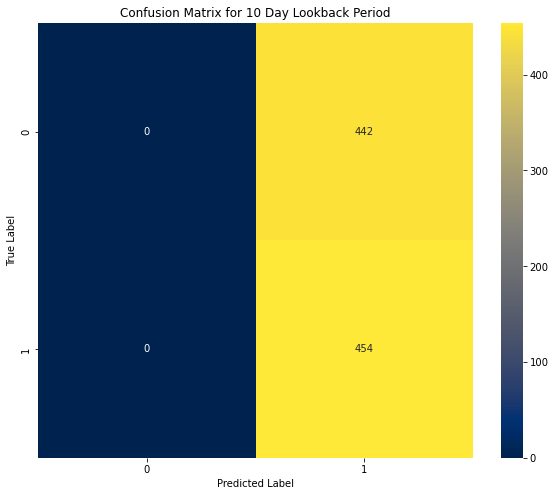

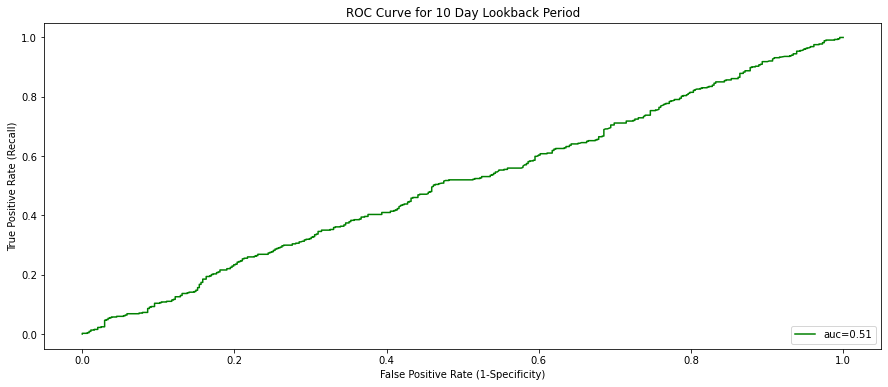

In [78]:
y_pred10=model10.predict(x_test_10)
y_pred10 = np.round(y_pred10).astype(int)
cm_10=confusion_matrix(y_test_10,y_pred10)
plt.figure(figsize=(10,8))
sns.heatmap(cm_10,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],cmap="cividis", square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 10 Day Lookback Period")

y_prob10=model10.predict(x_test_10)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_10,y_prob10),2)
fpr,tpr,_=roc_curve(y_test_10,y_prob10, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc), color='green')
plt.legend(loc="lower right")
plt.title("ROC Curve for 10 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

#### 2.4.3 Implementing an LSTM model with a 21-day lookback period

In [79]:
X_new21, y_new21 = lstm_data_transform(X, y, num_steps=21)

print(f"The new shape of X for num_steps=21 is {X_new21.shape}")

model21 = base_model(X_new21)

The new shape of X for num_steps=21 is (2974, 21, 12)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 21, 200)           170400    
_________________________________________________________________
dropout_35 (Dropout)         (None, 21, 200)           0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 21, 100)           120400    
_________________________________________________________________
dropout_36 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 21, 100)           80400     
_________________________________________________________________
dropout_37 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________


In [80]:
num_steps = [5, 10, 21, 50, 200]

x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

for n in num_steps:
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
x_train_21 = x_train_list[2]
y_train_21 = y_train_list[2]
x_test_21 = x_test_list[2]
y_test_21 = y_test_list[2]

hist21=model21.fit(x_train_21,y_train_21,epochs=10,batch_size=64)
Eva21=model21.evaluate(x_test_21,y_test_21)
print('Test accuracy: ', np.round(Eva21[1],4))

Epoch 1/10
33/33 [==============================] - 46s 824ms/step - loss: 0.6960 - accuracy: 0.5156
Epoch 2/10
33/33 [==============================] - 24s 741ms/step - loss: 0.6998 - accuracy: 0.4709
Epoch 3/10
33/33 [==============================] - 26s 786ms/step - loss: 0.6960 - accuracy: 0.5031
Epoch 4/10
33/33 [==============================] - 25s 750ms/step - loss: 0.6955 - accuracy: 0.4877
Epoch 5/10
33/33 [==============================] - 24s 725ms/step - loss: 0.6956 - accuracy: 0.4849
Epoch 6/10
33/33 [==============================] - 23s 707ms/step - loss: 0.6952 - accuracy: 0.5031
Epoch 7/10
33/33 [==============================] - 24s 743ms/step - loss: 0.6959 - accuracy: 0.4796
Epoch 8/10
33/33 [==============================] - 26s 773ms/step - loss: 0.6941 - accuracy: 0.4959
Epoch 9/10
33/33 [==============================] - 25s 757ms/step - loss: 0.6945 - accuracy: 0.4911
Epoch 10/10
28/28 [==============================] - 7s 132ms/step - loss: 0.6955 - accurac

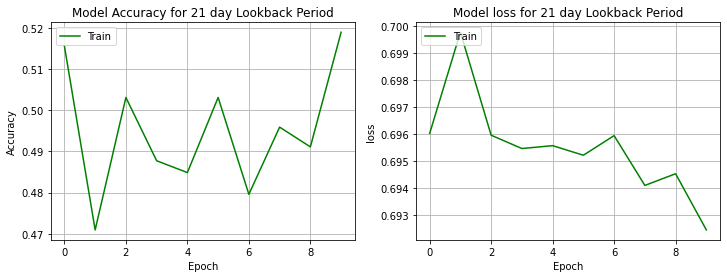

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


# Plot accuracy
ax1.plot(hist21.history['accuracy'], color='green')
ax1.set_title("Model Accuracy for 21 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')
ax1.grid()

# Plot loss
ax2.plot(hist21.history['loss'], color="green")
ax2.set_title('Model loss for 21 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')
ax2.grid()

plt.show()

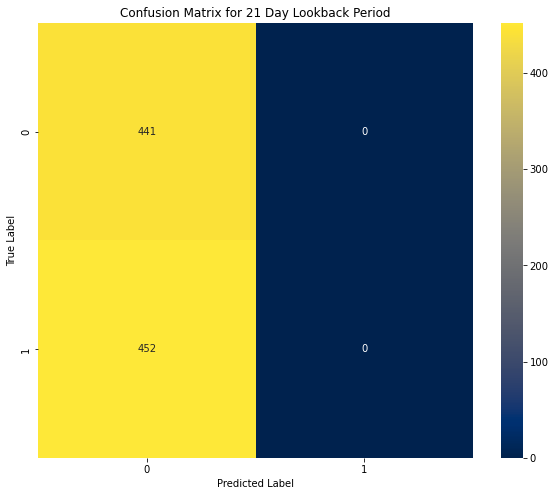

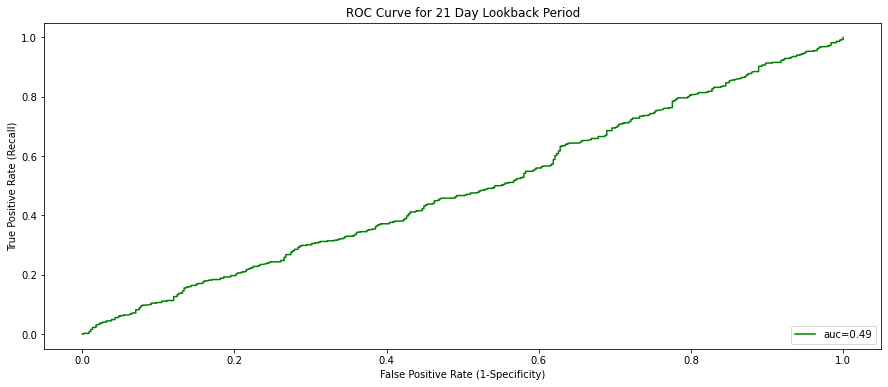

In [82]:
y_pred21=model21.predict(x_test_21)
y_pred21 = np.round(y_pred21).astype(int)
cm_21=confusion_matrix(y_test_21,y_pred21)
plt.figure(figsize=(10,8))
sns.heatmap(cm_21,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1],cmap="cividis",square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 21 Day Lookback Period")

y_prob21=model21.predict(x_test_21)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_21,y_prob21),2)
fpr,tpr,_=roc_curve(y_test_21,y_prob21, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc), color='green')
plt.legend(loc="lower right")
plt.title("ROC Curve for 21 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

#### 2.4.4 Implementing an LSTM model with a 50-day lookback period

In [83]:
X_new50, y_new50 = lstm_data_transform(X, y, num_steps=50)

print(f"The new shape of X for num_steps=50 is {X_new50.shape}")

model50 = base_model(X_new50)

The new shape of X for num_steps=50 is (2945, 50, 12)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 50, 200)           170400    
_________________________________________________________________
dropout_40 (Dropout)         (None, 50, 200)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 50, 100)           120400    
_________________________________________________________________
dropout_41 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________


In [84]:
num_steps = [5, 10, 21, 50, 200]

x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

for n in num_steps:
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
x_train_50 = x_train_list[3]
y_train_50 = y_train_list[3]
x_test_50 = x_test_list[3]
y_test_50 = y_test_list[3]

hist50=model50.fit(x_train_50,y_train_50,epochs=10,batch_size=64)
Eva50=model50.evaluate(x_test_50,y_test_50)
print('Test accuracy: ', np.round(Eva50[1],4))

Epoch 1/10
33/33 [==============================] - 73s 2s/step - loss: 0.6981 - accuracy: 0.5012
Epoch 2/10
33/33 [==============================] - 52s 2s/step - loss: 0.6966 - accuracy: 0.4978
Epoch 3/10
33/33 [==============================] - 59s 2s/step - loss: 0.6961 - accuracy: 0.5114
Epoch 4/10
33/33 [==============================] - 53s 2s/step - loss: 0.6982 - accuracy: 0.5022
Epoch 5/10
33/33 [==============================] - 54s 2s/step - loss: 0.6933 - accuracy: 0.5230
Epoch 6/10
33/33 [==============================] - 53s 2s/step - loss: 0.6986 - accuracy: 0.4930
Epoch 7/10
33/33 [==============================] - 47s 1s/step - loss: 0.6935 - accuracy: 0.5172
Epoch 8/10
33/33 [==============================] - 38s 1s/step - loss: 0.6943 - accuracy: 0.5036
Epoch 9/10
33/33 [==============================] - 40s 1s/step - loss: 0.6941 - accuracy: 0.5036
Epoch 10/10
28/28 [==============================] - 7s 174ms/step - loss: 0.6931 - accuracy: 0.5079
Test accuracy:  0

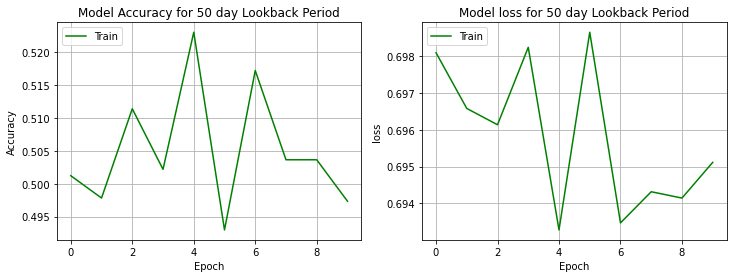

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist50.history['accuracy'], color='green')
ax1.set_title("Model Accuracy for 50 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')
ax1.grid()

# Plot loss
ax2.plot(hist50.history['loss'], color='green')
ax2.set_title('Model loss for 50 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')
ax2.grid()

plt.show()

#### Confusion Matrix

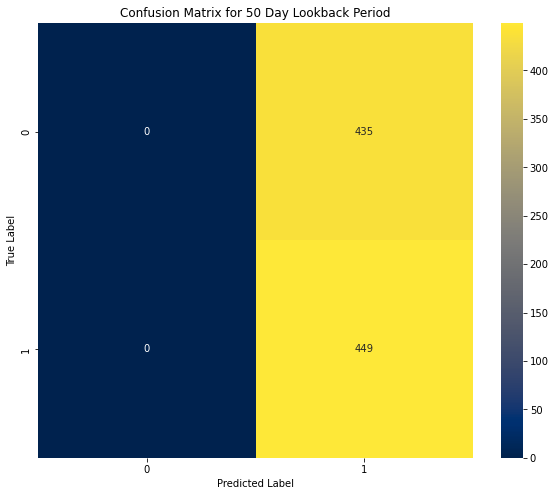

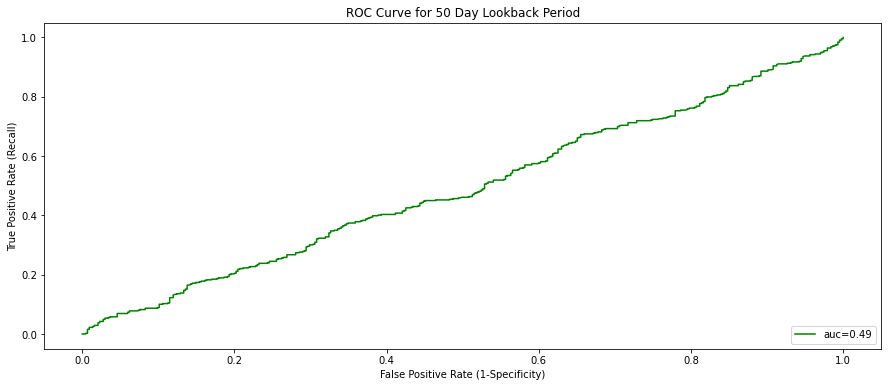

In [86]:
y_pred50=model50.predict(x_test_50)
y_pred50 = np.round(y_pred50).astype(int)
cm_50=confusion_matrix(y_test_50,y_pred50)
plt.figure(figsize=(10,8))
sns.heatmap(cm_50,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1], cmap='cividis',square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 50 Day Lookback Period")

y_prob50=model50.predict(x_test_50)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_50,y_prob50),2)
fpr,tpr,_=roc_curve(y_test_50,y_prob50, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc), color='green')
plt.legend(loc="lower right")
plt.title("ROC Curve for 50 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

#### 2.4.5 Implementing an LSTM model with a 200-day lookback period

In [87]:
X_new200, y_new200 = lstm_data_transform(X, y, num_steps=200)

print(f"The new shape of X for num_steps=200 is {X_new200.shape}")

model200 = base_model(X_new200)

The new shape of X for num_steps=200 is (2795, 200, 12)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 200, 200)          170400    
_________________________________________________________________
dropout_45 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 200, 100)          120400    
_________________________________________________________________
dropout_46 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
dropout_47 (Dropout)         (None, 200, 100)          0         
________________________________________________________________

In [88]:
num_steps = [5, 10, 21, 50, 200]

# Initialize lists to hold the train and test data for each num_steps value
x_train_list, y_train_list, x_test_list, y_test_list = [], [], [], []

# Loop through the different num_steps values
for n in num_steps:
    # Transform the data for the current num_steps value
    x_new, y_new = lstm_data_transform(X, y, num_steps=n)
    
    # Split the transformed data into train and test sets
    train_ind = int(0.7 * x_new.shape[0])
    x_train = x_new[:train_ind]
    y_train = y_new[:train_ind]
    x_test = x_new[train_ind:]
    y_test = y_new[train_ind:]
    
    # Append the train and test data to the respective lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
    
    
# Use the train and test data for num_steps=200 only
x_train_200 = x_train_list[4]
y_train_200 = y_train_list[4]
x_test_200 = x_test_list[4]
y_test_200 = y_test_list[4]

# Train and evaluate the model for num_steps=200
hist200=model200.fit(x_train_200,y_train_200,epochs=10,batch_size=64)
Eva200=model200.evaluate(x_test_200,y_test_200)
print('Test accuracy: ', np.round(Eva200[1],4))

Epoch 1/10
31/31 [==============================] - 157s 4s/step - loss: 0.7007 - accuracy: 0.4867
Epoch 2/10
31/31 [==============================] - 141s 5s/step - loss: 0.6987 - accuracy: 0.4964
Epoch 3/10
31/31 [==============================] - 140s 4s/step - loss: 0.6951 - accuracy: 0.5026
Epoch 4/10
31/31 [==============================] - 137s 4s/step - loss: 0.6955 - accuracy: 0.4980
Epoch 5/10
31/31 [==============================] - 139s 4s/step - loss: 0.6952 - accuracy: 0.5036
Epoch 6/10
31/31 [==============================] - 139s 4s/step - loss: 0.6946 - accuracy: 0.5041
Epoch 7/10
31/31 [==============================] - 180s 6s/step - loss: 0.6959 - accuracy: 0.4796
Epoch 8/10
31/31 [==============================] - 208s 7s/step - loss: 0.6939 - accuracy: 0.4934
Epoch 9/10
31/31 [==============================] - 199s 6s/step - loss: 0.6940 - accuracy: 0.4913
Epoch 10/10
27/27 [==============================] - 35s 1s/step - loss: 0.6942 - accuracy: 0.4934
Test accur

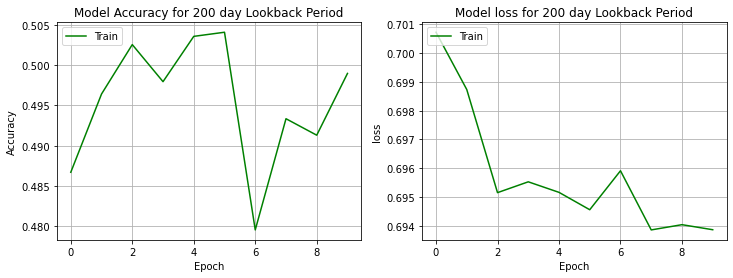

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(hist200.history['accuracy'], color='green')
ax1.set_title("Model Accuracy for 200 day Lookback Period")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(['Train'], loc='upper left')
ax1.grid()

# Plot loss
ax2.plot(hist200.history['loss'], color='green')
ax2.set_title('Model loss for 200 day Lookback Period')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train'], loc='upper left')
ax2.grid()

plt.show()

#### Confusion Matrix

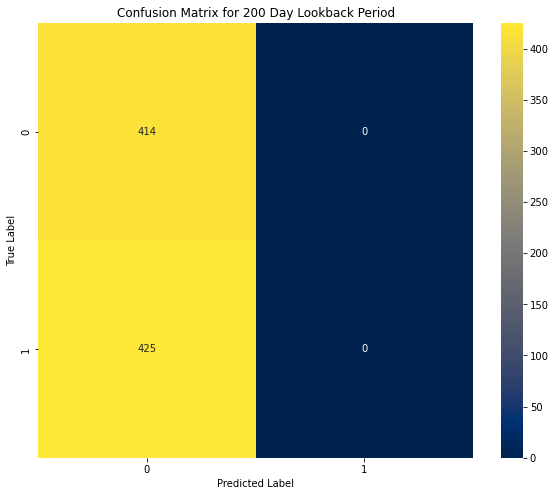

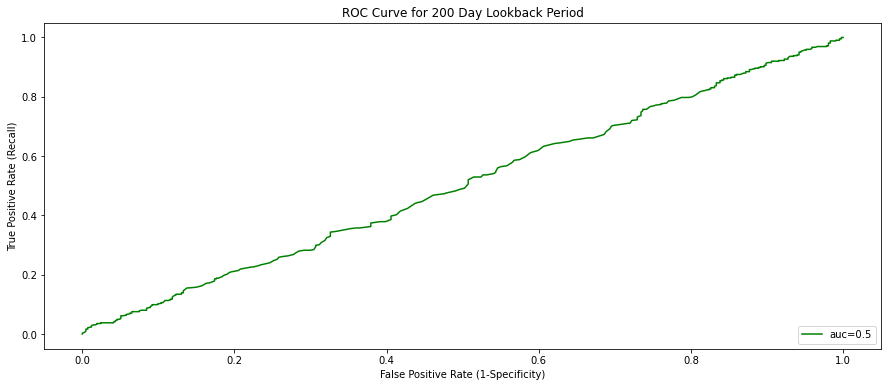

In [90]:
y_pred200=model200.predict(x_test_200)
y_pred200 = np.round(y_pred200).astype(int)
cm_200=confusion_matrix(y_test_200,y_pred200)
plt.figure(figsize=(10,8))
sns.heatmap(cm_200,annot=True,fmt='g',xticklabels=[0,1],yticklabels=[0,1], cmap='cividis',square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for 200 Day Lookback Period")

y_prob200=model200.predict(x_test_200)[:,0] # to get probability values of 1 
auc=round(roc_auc_score(y_test_200,y_prob200),2)
fpr,tpr,_=roc_curve(y_test_200,y_prob200, pos_label=1)
plt.figure(figsize=(15,6))
plt.plot(fpr,tpr,label="auc="+str(auc), color='green')
plt.legend(loc="lower right")
plt.title("ROC Curve for 200 Day Lookback Period")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()